In [2]:
import pandas as pd
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Read in data

df = pd.read_csv('so_survey.csv')

# Are you more likely to get a job if you have a bachelor's degree or higher? #

In [4]:
degree_values = [
    'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)',
    'Bachelor’s degree (B.A., B.S., B.Eng., etc.)',
    'Professional degree (JD, MD, Ph.D, Ed.D, etc.)'
]

#Dataframe to be filtered on education level
ed_df = df.copy()

# Create the 'degree' column
ed_df.loc[:, 'Degree'] = ed_df['EdLevel'].apply(lambda x: "Has Degree" if x in degree_values else 'No Degree')
ed_df

,Age,Employment,RemoteWork,EdLevel,YearsCode,YearsCodePro,DevType,Country,WorkExp,Industry,ConvertedCompYearly,Degree
0,18-24 years old,Unemployed,NaN,"Associate degree (A.A., A.S., etc.)",2,NaN,NaN,Spain,NaN,NaN,NaN,No Degree
1,Under 18 years old,Unemployed,NaN,Primary/elementary school,2,NaN,NaN,India,NaN,NaN,NaN,No Degree
2,Under 18 years old,Unemployed,NaN,Primary/elementary school,5,NaN,NaN,Nepal,NaN,NaN,NaN,No Degree
3,35-44 years old,Independent/Self-employed,Remote,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",12,10,"Developer, back-end",South Africa,10.0,"Information Services, IT, Software Development...",103743.0,Has Degree
4,18-24 years old,Unemployed,NaN,Something else,10,NaN,NaN,Canada,NaN,NaN,NaN,No Degree
...,...,...,...,...,...,...,...,...,...,...,...,...
89179,35-44 years old,Employed,Remote,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",17,11,"Developer, full-stack",Mexico,12.0,Financial Services,NaN,Has Degree
89180,45-54 years old,Employed,Remote,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",25,22,"Developer, full-stack",United States of America,22.0,Insurance,NaN,Has Degree
89181,25-34 years old,Employed,Remote,"Associate degree (A.A., A.S., etc.)",20,5,"Developer, front-end",Brazil,NaN,NaN,NaN,No Degree
89182,Under 18 years old,Employed,"Hybrid (some remote, some in-person)","Secondary school (e.g. American high school, G...",3,NaN,System administrator,Switzerland,NaN,NaN,NaN,No Degree


In [10]:
# Filter the DataFrame to include only 'Employed' and 'Unemployed' persons and people based out of the U.s
filtered_df = ed_df[(ed_df['Employment'].isin(['Employed', 'Unemployed'])) & (ed_df['Country'] == 'United States of America')].copy()

pivot_table = filtered_df.pivot_table(
    index='Employment', 
    columns='Degree', 
    aggfunc='size', 
    fill_value=0)
    
print(pivot_table)

Degree      Has Degree  No Degree
Employment                       
Employed         11937       2731
Unemployed         455        403


In [11]:
# Extract observed frequencies
observed = pivot_table.values

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(observed)

# Print results
print(f"Chi2: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected)

Chi2: 402.6431159049229
P-value: 1.4640847697754593e-89
Degrees of Freedom: 1
Expected Frequencies:
[[11707.19154966  2960.80845034]
 [  684.80845034   173.19154966]]


In [12]:
# Create binary employment variable
filtered_df['Employed'] = filtered_df['Employment'].apply(lambda x: 1 if x == 'Employed' else 0)

# Create binary variable for having a degree
filtered_df['Degree'] = filtered_df['Degree'].apply(lambda x: 1 if x == 'Has Degree' else 0)


# Define the independent and dependent variables
X = filtered_df[['Degree']]
y = filtered_df['Employed']

# Add a constant to the independent variables
X = sm.add_constant(X)

# Fit the logistic regression model
model = sm.Logit(y, X).fit()

# Print the summary of the model
print(model.summary())

# Get the predicted probabilities
filtered_df['PredictedProb'] = model.predict(X)

# Print the predicted probabilities
print(filtered_df[['Degree', 'Employment', 'PredictedProb']])

Optimization terminated successfully.
         Current function value: 0.203053
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               Employed   No. Observations:                15526
Model:                          Logit   Df Residuals:                    15524
Method:                           MLE   Df Model:                            1
Date:                Tue, 09 Jul 2024   Pseudo R-squ.:                 0.04994
Time:                        10:46:11   Log-Likelihood:                -3152.6
converged:                       True   LL-Null:                       -3318.3
Covariance Type:            nonrobust   LLR p-value:                 4.643e-74
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9135      0.053     35.858      0.000       1.809       2.018
Degree         1.3536      0.

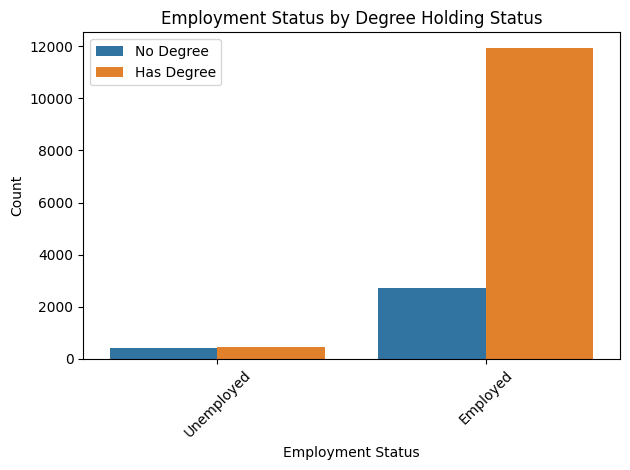

In [8]:
# Grouped bar plot
sns.countplot(x='Employment', hue='Degree', data=filtered_df)
plt.title('Employment Status by Degree Holding Status')
plt.xlabel('Employment Status')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(['No Degree', 'Has Degree'])
plt.tight_layout()
plt.show()

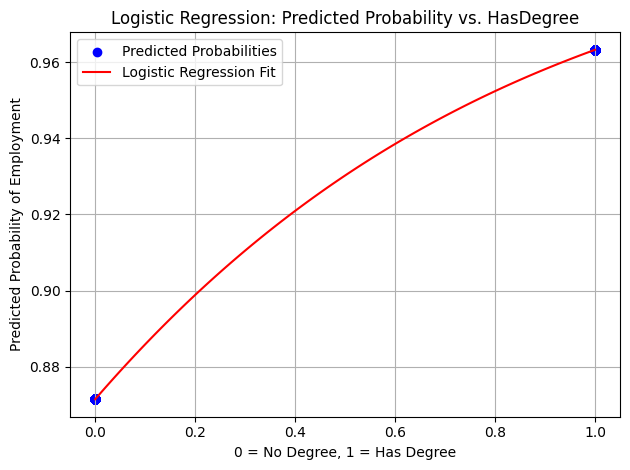

In [276]:
import numpy as np

# Generate data for plotting
x_vals = np.linspace(filtered_df['Degree'].min(), filtered_df['Degree'].max(), 100)
X_plot = sm.add_constant(x_vals)
pred_probs = model.predict(X_plot)

# Plot predicted probabilities
plt.scatter(filtered_df['Degree'], filtered_df['PredictedProb'], color='blue', label='Predicted Probabilities')
plt.plot(x_vals, pred_probs, color='red', label='Logistic Regression Fit')
plt.xlabel('0 = No Degree, 1 = Has Degree')
plt.ylabel('Predicted Probability of Employment')
plt.title('Logistic Regression: Predicted Probability vs. HasDegree')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Does the ability work remotely impact total compensation? #

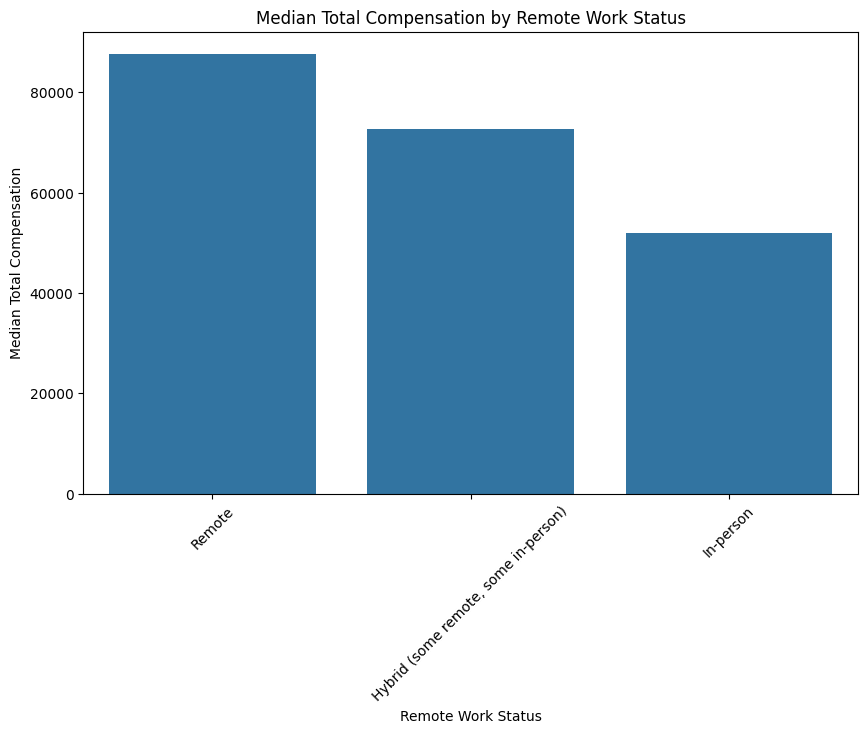

In [357]:
# Group by RemoteWork and calculate average TotalCompensation
remote_salary = df.groupby('RemoteWork')['ConvertedCompYearly'].median().sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=remote_salary.index, y=remote_salary.values)
plt.title('Median Total Compensation by Remote Work Status')
plt.xlabel('Remote Work Status')
plt.ylabel('Median Total Compensation')
plt.xticks(rotation=45)
plt.show()

In [358]:
remote_df = df[(df['RemoteWork'].notnull() & df['ConvertedCompYearly'].notnull())]

anova_result = f_oneway(remote_df[remote_df['RemoteWork'] == 'Remote']['ConvertedCompYearly'],
                              remote_df[remote_df['RemoteWork'] == 'Hybrid (some remote, some in-person)']['ConvertedCompYearly'],
                              remote_df[remote_df['RemoteWork'] == 'In-person']['ConvertedCompYearly'])

# Print ANOVA results
print("ANOVA p-value:", anova_result.pvalue)

ANOVA p-value: 4.590722723302765e-06


In [359]:
# Convert RemoteWork to dummy variables (indicator variables)
remote_df = pd.get_dummies(remote_df, columns=['RemoteWork'])


# Define predictor (independent) variables and response (dependent) variable
X = remote_df['RemoteWork_Remote'] # Independent variables (dummy variables)
y = remote_df['ConvertedCompYearly']  # Dependent variable

# Add intercept to predictor variables
X = sm.add_constant(X)

# Fit linear regression model
linear_model = sm.OLS(y, X).fit()

# Print regression results
print(linear_model.summary())


                             OLS Regression Results                            
Dep. Variable:     ConvertedCompYearly   R-squared:                       0.000
Model:                             OLS   Adj. R-squared:                  0.000
Method:                  Least Squares   F-statistic:                     12.30
Date:                 Thu, 27 Jun 2024   Prob (F-statistic):           0.000453
Time:                         18:11:59   Log-Likelihood:            -7.0527e+05
No. Observations:                47940   AIC:                         1.411e+06
Df Residuals:                    47938   BIC:                         1.411e+06
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              9.302e+04